In [2]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 100:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./loo_pft.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, plot_performance, score2
from conceptor.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [3]:
mfile = '../../checkpoint/latest/pretrainer.pt'
pretrainer = loadconceptor(mfile)

data_path = '../../00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))

df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))[pretrainer.feature_name]
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 110))

In [4]:
tmb_cohorts = ['IMVigor210', 'Rose', 'Liu', 'Riaz']

In [5]:
df_label = df_label[~df_label.real_TMB.isna()]
df_label = df_label[df_label.cohort.isin(tmb_cohorts)]
df_label['log2_TMB'] = np.log2(df_label.real_TMB + 1)
df_tpm = df_tpm.loc[df_label.index]

In [6]:
size = df_label.groupby('cohort').size()
size = size.index + "\n(n = " + size.astype(str) + ")"

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()
from sklearn.model_selection import LeaveOneOut

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfy = df_label.response_label
dfg_score, dfc_score = pretrainer.extract(dfcx, batch_size=16)
dfc = dfc_score[dfc_score.columns.difference(['Reference'])]

100%|##########| 30/30 [00:03<00:00,  9.46it/s]


In [7]:
df_tmb = dfc[['TMB']].join(df_label[['log2_TMB', 'cohort', 'cancer_type']]) 

In [8]:
df_tmb.head()

,TMB,log2_TMB,cohort,cancer_type
Index,,,,
IMVigor210-0257bb-ar-0257bbb,0.247796,4.247928,IMVigor210,BLCA
IMVigor210-025b45-ar-025b45c,0.168329,1.000000,IMVigor210,BLCA
IMVigor210-032c64-ar-032c642,0.293963,5.491853,IMVigor210,BLCA
IMVigor210-0571f1-ar-0571f17,0.231509,1.584963,IMVigor210,BLCA
IMVigor210-065890-ar-0658907,0.233928,3.169925,IMVigor210,BLCA


In [9]:
df_tmb.groupby('cohort').apply(lambda x:x.corr().loc['log2_TMB']['TMB'])

cohort
IMVigor210    0.357731
Liu           0.321652
Riaz          0.404734
Rose          0.216376
dtype: float64

In [10]:
size.index

Index(['IMVigor210', 'Liu', 'Riaz', 'Rose'], dtype='object', name='cohort')

In [11]:
from conceptor.decoder import ProtoNetNFTDecoder
loo = LeaveOneOut()

In [12]:
dfco = dfc[dfc.columns.difference(['TMB'])]
dfts = dfco.join(dfc.TMB)
dftr = dfco.join(df_label.log2_TMB)
dftt = dfco.join(dfc.TMB).join(df_label.log2_TMB)

In [13]:
res = []
for dfx_used, mode in zip([dfco, dfts, dftr], ['NFT excluding\nTMB-score(p=44)',
                                              'NFT including\nTMB-score(p=45)', 
                                              'NFT including\nactual-TMB(p=45)', 
                                              ]): #'with_TMB_both\n(p=46)' , dftt

    print(dfx_used.shape)
    for cohort in tqdm(cohorts, ascii=True):
    
        cohort_idx = df_label[df_label['cohort'] == cohort].index
        cohort_X = dfx_used.loc[cohort_idx]
        cohort_y = dfy.loc[cohort_idx]
    
        test_cohort_name = cohort
    
        predict_res = []
        for train_idx, test_idx in loo.split(cohort_idx):
            
            train_X = cohort_X.iloc[train_idx]
            train_y = cohort_y.iloc[train_idx]
            test_X = cohort_X.iloc[test_idx]    
            test_y = cohort_y.iloc[test_idx]
        
            support_set = train_X.join(train_y)
            query_set = test_X.join(test_y)
            
            NFT = ProtoNetNFTDecoder()
            NFT = NFT.fit(support_set)
            pred_testy = NFT.transform(query_set)
            
            pred_testy['cohort'] = test_cohort_name
            pred_testy['mode'] = mode
            predict_res.append(pred_testy)
    
        df_pred = pd.concat(predict_res)
        dfp = onehot(cohort_y.map({'PD':'NR', 'PR':'R',
                                   'SD':'NR', 'CR':'R',
                                   'NR':'NR', 'R':'R'})).join(df_pred)
        
        y_true, y_prob, y_pred = dfp['R'], dfp[1], dfp[[0, 1]].idxmax(axis=1)
        s2 = score2(y_true, y_prob, y_pred)

        
        dfs = pd.DataFrame([s2], columns = ['ROC', 'PRC', 'F1', 'ACC', 'MCC'], index = ['Test'])
        dfs['cohort'] = test_cohort_name
        dfs['mode'] = mode
        res.append(dfs)

(475, 44)


100%|##########| 4/4 [00:03<00:00,  1.28it/s]


(475, 45)


100%|##########| 4/4 [00:03<00:00,  1.31it/s]


(475, 45)


100%|##########| 4/4 [00:03<00:00,  1.19it/s]


In [14]:
df = pd.concat(res).reset_index(drop=True)

In [15]:
df.cohort = df.cohort.map(size)

In [16]:
y_order = df.groupby('mode')['ACC'].mean().sort_values(ascending=False).index.tolist()
x_order = df.groupby('cohort')['ACC'].median().sort_values(ascending=False).index.tolist()

In [17]:
sns.palettes.color_palette('bright', 10)

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [18]:
c1 = sns.palettes.color_palette('Set2')[-1]
c2 = sns.palettes.color_palette('bright')[-1]
c3 = sns.palettes.color_palette('bright')[0]

In [19]:
palette = [c1, c2, c3]

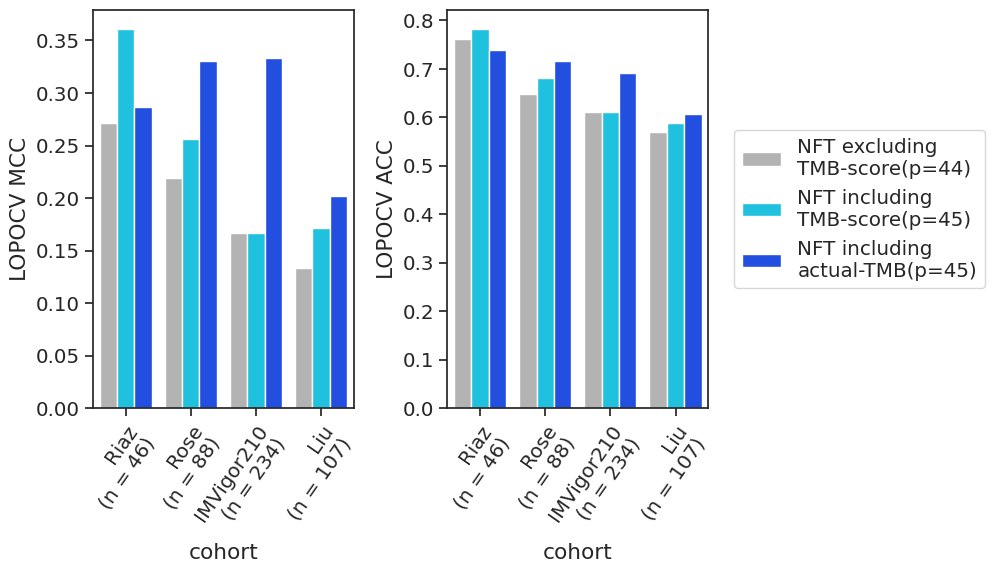

In [20]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2)

ax1, ax2 = axes

sns.barplot(data = df, x = 'cohort', y = 'MCC', hue = 'mode' , ax=ax1,
            palette=palette,  order = x_order,)
ax1.set_ylabel('LOPOCV MCC')

sns.barplot(data = df, x = 'cohort', y = 'ACC', hue = 'mode' , ax=ax2,
            palette=palette,  order = x_order,)
ax2.set_ylabel('LOPOCV ACC')

for ax in axes:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    ax.legend([],[], frameon=False)
    ax.set_xticklabels(
        x_order, 
        rotation=55, 
        ha="right",  
        rotation_mode="anchor")  # <====== HERE is the ke

    
ax2.legend(bbox_to_anchor=(2.1, 0.5),loc = 'center right' , ncols =1)

fig.tight_layout()
fig.savefig('no_finetune_NFT_with_without_TMB.pdf')


In [22]:
df.to_csv('no_finetune_NFT_with_without_TMB.csv')